<a href="https://colab.research.google.com/github/HuangLorenzo/Esame_python/blob/main/Huang_lorenzo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [202]:
!pip install optuna
import optuna

In [203]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
SFRH_simulazioni = np.load('/content/drive/MyDrive/Colab Notebooks/esamepython/SFRH_IllustrisTNG.npy')
param_simulazioni=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/esamepython/params_IllustrisTNG.txt')

In [206]:
def has_duplicates(arr):
  # Convert each row to a tuple and then use np.unique to find unique tuples
  unique_rows = np.unique(arr, axis=0)
  return len(unique_rows) != len(arr)

# Example usage
vector_of_vectors = param_simulazioni
if has_duplicates(vector_of_vectors):
  print("The vector of vectors has duplicates.")
else:
  print("The vector of vectors does not have duplicates.")

The vector of vectors does not have duplicates.


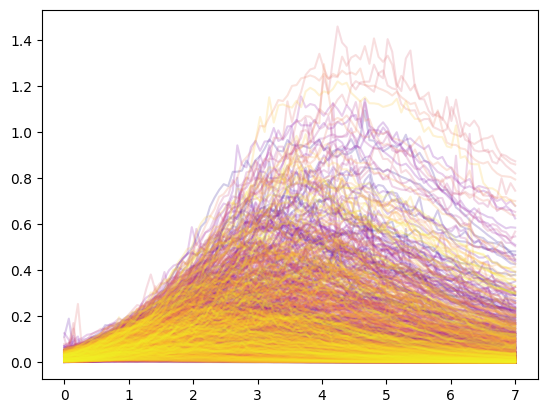

In [207]:
z=np.linspace(0.0, 7.0, 100)
cmap=plt.get_cmap('plasma')
colors=[cmap(i) for i in np.linspace(0,1,len(SFRH_simulazioni))]
for i in range(len(SFRH_simulazioni)):
  plt.plot(z,SFRH_simulazioni[i],c=colors[i], alpha=0.2)
plt.show()

In [208]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 12                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-3                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 500                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

In [209]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):
        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std







        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,100), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,6),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [210]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [211]:
train_loader = create_dataset('train', SFRH_simulazioni, param_simulazioni, batch_size, seed)
valid_loader = create_dataset('valid', SFRH_simulazioni, param_simulazioni, batch_size, seed)
test_loader  = create_dataset('test', SFRH_simulazioni, param_simulazioni, batch_size, seed)

In [212]:
def model_builder(number_layers,hidden_size):
  layers=[]

  #creazione del modello
  layers.append(nn.Linear(100,hidden_size))
  for i in range(number_layers):
    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_size,hidden_size))
  layers[2*number_layers]=nn.Linear(hidden_size,6)

  return nn.Sequential(*layers)


In [213]:
def nn_training(model,lr,epochs,trial=None):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
  min_valid_loss=min_valid_loss_param
  train_value=np.zeros(epochs)
  valid_value=np.zeros(epochs)
  global epoch_best_model

  # update the learning rate after patience-stesp if the loss function does not improve
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-6)




  #funzioneloss
  loss_func = nn.MSELoss()


  for epoch in range(epochs):
    train_loss = 0.0
    points=0.0
    model.train()
    for i, (input, output) in enumerate(train_loader):
      # get the size of the batch
      bs = input.shape[0]

      #spostare i dati nel GPU se è disponibile
      input = input.to(device)
      output = output.to(device)

      #modello output
      output_pred = model(input)

      #calcolo scarto medio quadratico
      loss = loss_func(output_pred, output)

      #gradiente
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #accumulo loss del ciclo sui batch
      train_loss += loss.item()*bs
      points+=bs

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss

    #validation
    valid_loss = 0.0
    points=0.0
    model.eval()


    #disattivo gradiente
    with torch.no_grad():

      #ciclo valid_batch
      for i, (input, output) in enumerate(valid_loader):
       # get the size of the batch
        bs = input.shape[0]

        #spostare i dati nel GPU se è disponibile
        input = input.to(device)
        output = output.to(device)

        #modello output
        output_pred = model(input)

        #calcolo scarto medio quadratico
        loss = loss_func(output_pred, output)

        #accumula loss
        valid_loss += (loss.item())*bs
        points     += bs

      valid_loss/=points
      valid_value[epoch]=valid_loss

    #attivo scheduler
    scheduler.step(valid_loss)

    # save model if it has a lower validation loss

    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break
    if trial is not None:
      trial.report(min_valid_loss, epoch)
      if trial.should_prune():
        raise optuna.TrialPruned()
  return train_value,valid_value,min_valid_loss

In [214]:
#costruisci sempre un modello prima del training senno il trainig parte da parametri gia ottimizzati
model=model_builder(1,hidden_size=hidden_size)
model=model.to(device)
print(model)

train_value,valid_value,_=nn_training(model=model,lr=lr,epochs=epochs)

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=6, bias=True)
)
Training stop at epoch: 444  because the best model does not imporved after  200  epochs


[]

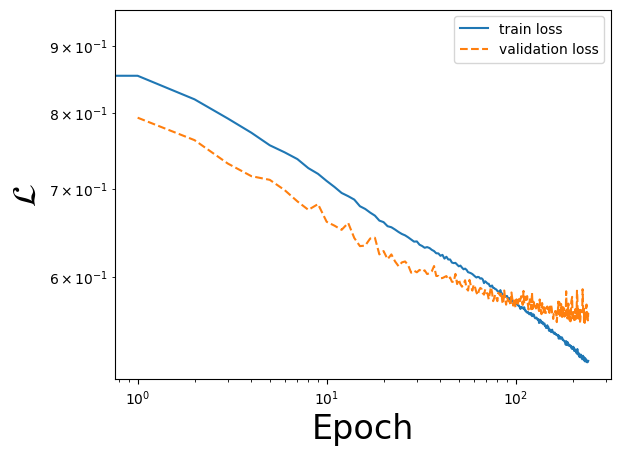

In [215]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

test loss = 5.872e-01


<ipython-input-216-ff77a21d89b2>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



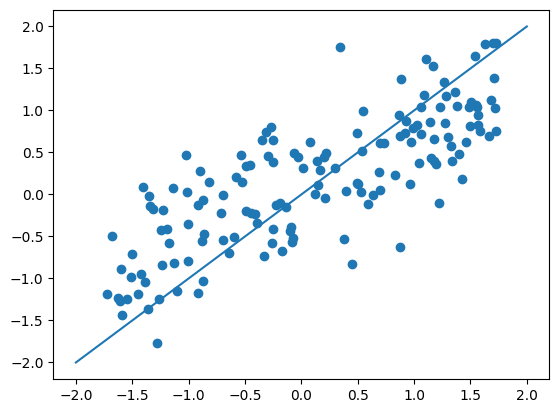

In [216]:
loss_func = nn.MSELoss()

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((len(test_loader.dataset),100))
y_true=np.zeros((len(test_loader.dataset),6))
y_NN=np.zeros((len(test_loader.dataset),6))

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
with torch.no_grad():
  for x_test, y_test in test_loader:
    bs=x_test.shape[0]

    # move data to GPU
    x_test   = x_test.to(device)
    y_test = y_test.to(device)

    # make prediction using network
    y_pred = model(x_test)

    # Store predictions and true parameter values
    # Need to move the array to cpu() and make it numpy()
    # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
    # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
    x_values[counter:counter+bs,:]=x_test
    y_true[counter:counter+bs,:]= y_test.cpu().numpy()
    y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


    # compute cumulative loss and number of examples used
    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

    counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)
plt.plot(np.linspace(-2,2,1000),np.linspace(-2,2,1000))
plt.scatter(y_true[:,0],y_NN[:,0],label='$\Omega_m$')

In [217]:
def objective(trial):
  params = {
      'number_layers': trial.suggest_int('number_layers', 1, 4,),
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
      'epochs': trial.suggest_int("epochs", 100, 500),
      'hidden_size': trial.suggest_int("hidden_size", 50, 100) # number of hidden parameters
       }
  #salvo i nuovi parametri
  number_layers=params['number_layers']
  hidden_size=params['hidden_size']
  lr=params['learning_rate']
  epochs=params['epochs']

  #costruisco modello
  model=model_builder(number_layers=number_layers,hidden_size=hidden_size)
  model=model.to(device)


  #accuracy

  _,_,accuracy=nn_training(model=model,lr=lr,epochs=epochs,trial=trial)

  return accuracy




In [218]:
# Let's also add a method (prune) to terminate unpromising trials in the early stages of the training process
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=30)

[I 2025-02-16 22:05:49,139] A new study created in memory with name: no-name-aa29a56b-3dde-428c-993c-f316bba9c012
[I 2025-02-16 22:06:09,607] Trial 0 finished with value: 0.6128152680397033 and parameters: {'number_layers': 1, 'learning_rate': 0.030788859000035394, 'epochs': 235, 'hidden_size': 75}. Best is trial 0 with value: 0.6128152680397033.
[I 2025-02-16 22:06:36,423] Trial 1 finished with value: 0.7454932141304016 and parameters: {'number_layers': 4, 'learning_rate': 0.02592879226031521, 'epochs': 193, 'hidden_size': 60}. Best is trial 0 with value: 0.6128152680397033.
[I 2025-02-16 22:06:50,918] Trial 2 finished with value: 0.5532623600959777 and parameters: {'number_layers': 2, 'learning_rate': 0.000345064436566386, 'epochs': 140, 'hidden_size': 70}. Best is trial 2 with value: 0.5532623600959777.
[I 2025-02-16 22:07:29,761] Trial 3 finished with value: 0.5213448476791381 and parameters: {'number_layers': 3, 'learning_rate': 0.0006660634584476096, 'epochs': 317, 'hidden_size':

Training stop at epoch: 252  because the best model does not imporved after  200  epochs


[I 2025-02-16 22:10:50,850] Trial 11 finished with value: 0.5279332160949707 and parameters: {'number_layers': 3, 'learning_rate': 0.0010782770819697358, 'epochs': 321, 'hidden_size': 50}. Best is trial 3 with value: 0.5213448476791381.
[I 2025-02-16 22:11:26,321] Trial 12 finished with value: 0.5212411201000213 and parameters: {'number_layers': 3, 'learning_rate': 0.00191187198730102, 'epochs': 287, 'hidden_size': 50}. Best is trial 12 with value: 0.5212411201000213.
[I 2025-02-16 22:11:59,268] Trial 13 finished with value: 0.5206317710876465 and parameters: {'number_layers': 3, 'learning_rate': 0.0023815328136332775, 'epochs': 280, 'hidden_size': 56}. Best is trial 13 with value: 0.5206317710876465.


Training stop at epoch: 254  because the best model does not imporved after  200  epochs


[I 2025-02-16 22:12:32,919] Trial 14 pruned. 
[I 2025-02-16 22:13:01,308] Trial 15 pruned. 
[I 2025-02-16 22:13:31,444] Trial 16 pruned. 
[I 2025-02-16 22:13:49,715] Trial 17 finished with value: 0.5278303003311158 and parameters: {'number_layers': 4, 'learning_rate': 0.007290855580652127, 'epochs': 112, 'hidden_size': 90}. Best is trial 13 with value: 0.5206317710876465.
[I 2025-02-16 22:14:26,962] Trial 18 finished with value: 0.5187495851516724 and parameters: {'number_layers': 3, 'learning_rate': 0.0016905772716525817, 'epochs': 376, 'hidden_size': 66}. Best is trial 18 with value: 0.5187495851516724.
[I 2025-02-16 22:14:27,093] Trial 19 pruned. 


Training stop at epoch: 276  because the best model does not imporved after  200  epochs


[I 2025-02-16 22:15:00,366] Trial 20 pruned. 
[I 2025-02-16 22:15:32,564] Trial 21 finished with value: 0.5201063871383667 and parameters: {'number_layers': 3, 'learning_rate': 0.0016163460623971173, 'epochs': 279, 'hidden_size': 56}. Best is trial 18 with value: 0.5187495851516724.


Training stop at epoch: 248  because the best model does not imporved after  200  epochs


[W 2025-02-16 22:15:40,358] Trial 22 failed with parameters: {'number_layers': 3, 'learning_rate': 0.0013949446125925166, 'epochs': 361, 'hidden_size': 56} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-217-60d69dba621b>", line 21, in objective
    _,_,accuracy=nn_training(model=model,lr=lr,epochs=epochs,trial=trial)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-213-c2fc92551f55>", line 39, in nn_training
    optimizer.step()
  File "/usr/local/lib/python3.11/dist-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/optim/optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-218-a2281cbea1c5>", line 3, in <cell line: 0>
    study.optimize(objective, n_trials=30)
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/study.py", line 475, in optimize
    _optimize(
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 63, in _optimize
    _optimize_sequential(
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 160, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 248, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(tria

TypeError: object of type 'NoneType' has no len()

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
# Generate a visualization of the intermediate values recorded during the
# hyperparameter optimization process
optuna.visualization.plot_intermediate_values(study)

In [ ]:
# Plot how the best objective function value found so far changes as the
# optimization progresses (i.e., as more trials are completed)
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize the relationships between multiple hyperparameters and their
# impact on the objective function (e.g., validation loss) that you're trying to
# optimize.

# Vertical Axes: Each vertical axis represents a hyperparameter or the objective value (e.g. validation loss) that's being optimized.
# Lines: Each line represents a single trial in your optimization. The point where a line intersects with an axis corresponds to the value of that hyperparameter (or the objective value) for that trial.
# Color: Often, the lines are colored according to the objective function value (e.g., trials with lower validation loss might be a different color).

optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# Visualize the relative importance of the hyperparameters in optimazing the
# objective function (e.g., validation loss)
optuna.visualization.plot_param_importances(study)